분석의 목적 
- 분양가 상한제가 폐지가 되면 건축비와 분양가가 높아질텐데 그렇게 되면 청약의 경우도 차익에 대한 매력이 떨어지기도 하고 높은 분양가로 인해 미분양이 많이 생길텐데 이론상으로는 주택가격이 떨어지는 그림이 그려진다. 실제로 데이터는 어떤지 알아보자.
- 공급이 많아지니깐 전세가는 안정될것이다?

In [1]:
import sys
base_path = 'C:\\github\\aide-analysis'
sys.path.append(base_path)

from core.config import Config
config = Config()
config.RAWDATA_PATH

# 사전처리
from src.temp import *
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import datetime
import glob
import re
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings(action='ignore')

# DataFrame 디스플레이 설정
pd.set_option('display.max_columns', 250)
pd.set_option('display.max_rows', 250)
pd.set_option('display.width', 100)
# Pandas Float 자릿수 표시 제한
pd.options.display.float_format = '{:.2f}'.format

# jupyter notebook 내 그래프를 바로 그리기 위한 설정
%matplotlib inline
# unicode minus를 사용하지 않기 위한 설정 (minus 깨짐현상 방지)
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'Malgun Gothic'

In [2]:
# 빅쿼리 연결
from src.bigquery import bigquery_client, bigquery
bq = bigquery_client

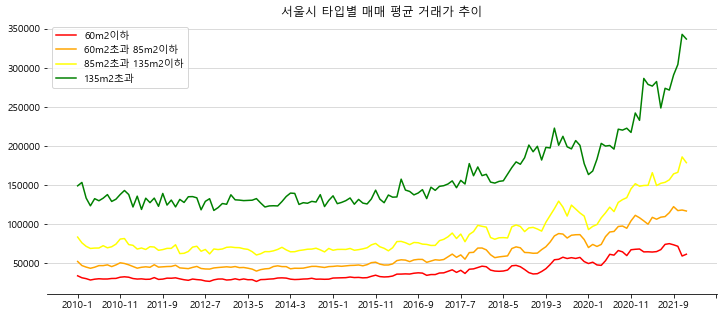

In [3]:


sql = f"""
SELECT T1.contractYear,
       T1.contractMonth, 
       T1.pyeong, 
       AVG(T1.transactionPrice)
FROM(
        SELECT contractYear,
               contractMonth,
               transactionPrice,
               CASE 
               WHEN jeonyongArea <= 60 THEN '60m2이하'
               WHEN jeonyongArea > 60 AND jeonyongArea <=85 THEN '60m2초과 85m2이하'
               WHEN jeonyongArea >85 AND jeonyongArea <=135 THEN '85m2초과 135m2이하'
               ELSE '135m2초과' 
               END AS pyeong
        FROM `aidepartners.aide.transaction_price_apartment_trading`
        WHERE contractYear >=2010 and 
              contractYear <=2021 and
              pnuCode LIKE '11%'
    ) AS T1 
GROUP BY T1.contractYear, T1.contractMonth, pyeong
ORDER BY T1.contractYear, T1.contractMonth, pyeong;
"""
df = bq.query(sql).to_dataframe()

df[['contractYear','contractMonth']] = df[['contractYear','contractMonth']].astype('str')
df['date']= df['contractYear'] + '-' + df['contractMonth']

df1 = df[df['pyeong']=='60m2이하']
df2 = df[df['pyeong']=='60m2초과 85m2이하']
df3 = df[df['pyeong']=='85m2초과 135m2이하']
df4 = df[df['pyeong']=='135m2초과']
fig, ax = plt.subplots(figsize = (12, 5))
ax.plot(df1['date'], df1['f0_'],c = 'red',label = '60m2이하')
ax.plot(df2['date'], df2['f0_'],c = 'orange',label = '60m2초과 85m2이하')
ax.plot(df3['date'], df3['f0_'],c = 'yellow',label = '85m2초과 135m2이하')
ax.plot(df4['date'], df4['f0_'],c = 'green',label = '135m2초과')

# xticks개수 조절
ax.xaxis.set_major_locator(MaxNLocator(16)) 

# 그리드 추가
ax.grid(axis="y", c="lightgray") # "axis = 'x'" 는 x축 세로선 grid생성

# 필요없는 선 제거
ax.spines[["left", "top", "right"]].set_visible(False)



plt.title('서울시 타입별 매매 평균 거래가 추이')
plt.legend()

위에 있는 시각화 자료를 통해서는 인사이트를 얻기 힘들어 보인다. 다른 시각화 방법을 사용해보자

In [4]:
# 매매가를 통화가치가 아닌 기준날짜로 지수화 (어느정도 올랐는지를 확인하기위함(개별 타입별))
df1['f0_'] = df1['f0_'].apply(lambda x: (x/df1['f0_'].iloc[0])-1 )
df2['f0_'] = df2['f0_'].apply(lambda x: (x/df2['f0_'].iloc[0])-1 )
df3['f0_'] = df3['f0_'].apply(lambda x: (x/df3['f0_'].iloc[0])-1 )
df4['f0_'] = df4['f0_'].apply(lambda x: (x/df4['f0_'].iloc[0])-1 )

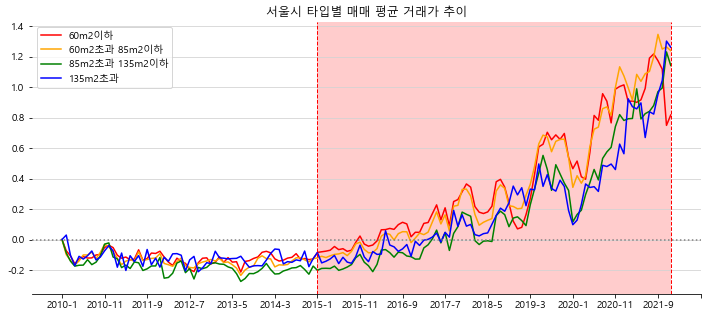

In [47]:
fig, ax = plt.subplots(figsize = (12, 5))
ax.plot(df1['date'], df1['f0_'],c = 'red',label = '60m2이하')
ax.plot(df2['date'], df2['f0_'],c = 'orange',label = '60m2초과 85m2이하')
ax.plot(df3['date'], df3['f0_'],c = 'green',label = '85m2초과 135m2이하')
ax.plot(df4['date'], df4['f0_'],c = 'blue',label = '135m2초과')

# xticks개수 조절
ax.xaxis.set_major_locator(MaxNLocator(16)) 

# 그리드 추가
ax.grid(axis="y", c="lightgray") # "axis = 'x'" 는 x축 세로선 grid생성

# 필요없는 선 제거
ax.spines[["left", "top", "right"]].set_visible(False)

# 0점선
ax.axhline(y=0, c="gray", ls=":") 

# 분양권 상한제 시점 표시
ax.axvspan('2015-1', '2021-12', facecolor='red',alpha = 0.2)
plt.axvline(x='2015-1', color='r', linestyle='--', linewidth=1)
plt.axvline(x='2021-12', color='r', linestyle='--', linewidth=1)


plt.title('서울시 타입별 매매 평균 거래가 추이')
plt.legend()

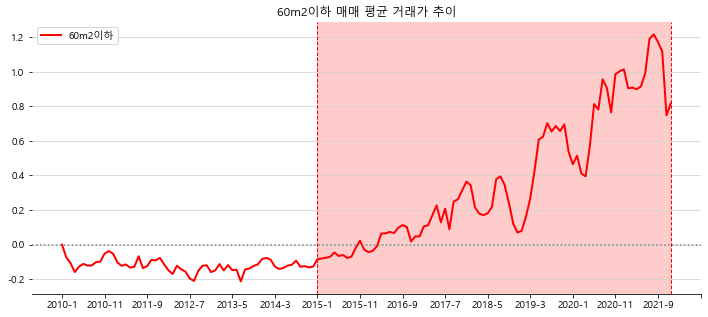

In [41]:
fig, ax = plt.subplots(figsize = (12, 5))
ax.plot(df1['date'], df1['f0_'],c = 'red',label = '60m2이하',linewidth =2)

# xticks개수 조절
ax.xaxis.set_major_locator(MaxNLocator(16)) 

# 그리드 추가
ax.grid(axis="y", c="lightgray") # "axis = 'x'" 는 x축 세로선 grid생성

# 필요없는 선 제거
ax.spines[["left", "top", "right"]].set_visible(False)

# 0점선
ax.axhline(y=0, c="gray", ls=":") 

# 분양권 상한제 시점 표시
ax.axvspan('2015-1', '2021-12', facecolor='red',alpha = 0.2)
plt.axvline(x='2015-1', color='r', linestyle='--', linewidth=1)
plt.axvline(x='2021-12', color='r', linestyle='--', linewidth=1)

plt.title('60m2이하 매매 평균 거래가 추이')
plt.legend()

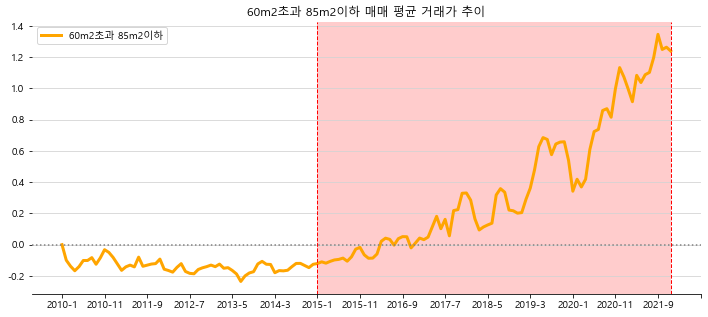

In [46]:
fig, ax = plt.subplots(figsize = (12, 5))
ax.plot(df2['date'], df2['f0_'],c = 'orange',label = '60m2초과 85m2이하',linewidth = 3)

# xticks개수 조절
ax.xaxis.set_major_locator(MaxNLocator(16)) 

# 그리드 추가
ax.grid(axis="y", c="lightgray") # "axis = 'x'" 는 x축 세로선 grid생성

# 필요없는 선 제거
ax.spines[["left", "top", "right"]].set_visible(False)

# 0점선
ax.axhline(y=0, c="gray", ls=":") 

# 분양권 상한제 시점 표시
ax.axvspan('2015-1', '2021-12', facecolor='red',alpha = 0.2)
plt.axvline(x='2015-1', color='r', linestyle='--', linewidth=1)
plt.axvline(x='2021-12', color='r', linestyle='--', linewidth=1)

plt.title('60m2초과 85m2이하 매매 평균 거래가 추이')
plt.legend()

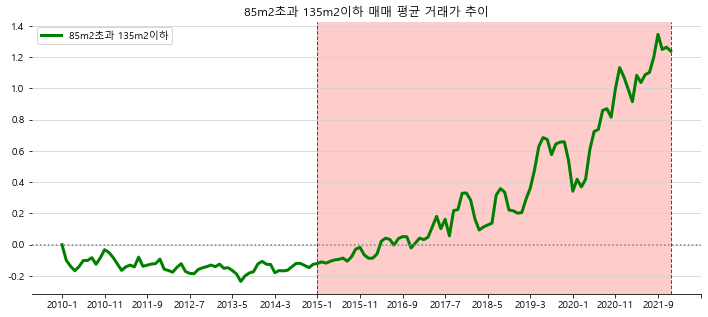

In [42]:
fig, ax = plt.subplots(figsize = (12, 5))
ax.plot(df2['date'], df2['f0_'],c = 'green',label = '85m2초과 135m2이하',linewidth = 3)

# xticks개수 조절
ax.xaxis.set_major_locator(MaxNLocator(16)) 

# 그리드 추가
ax.grid(axis="y", c="lightgray") # "axis = 'x'" 는 x축 세로선 grid생성

# 필요없는 선 제거
ax.spines[["left", "top", "right"]].set_visible(False)

# 0점선
ax.axhline(y=0, c="gray", ls=":") 

# 분양권 상한제 시점 표시
ax.axvspan('2015-1', '2021-12', facecolor='red',alpha = 0.2)
plt.axvline(x='2015-1', color='r', linestyle='--', linewidth=1)
plt.axvline(x='2021-12', color='r', linestyle='--', linewidth=1)

plt.title('85m2초과 135m2이하 매매 평균 거래가 추이')
plt.legend()

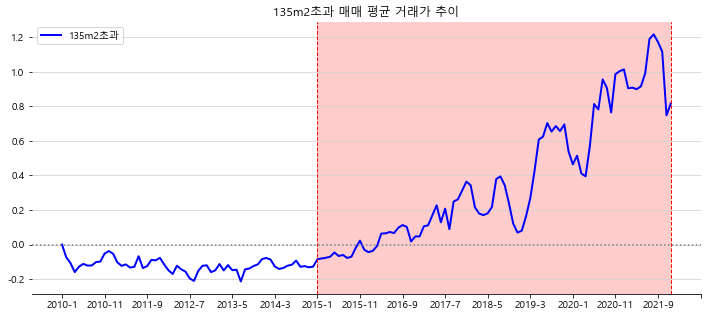

In [45]:
fig, ax = plt.subplots(figsize = (12, 5))
ax.plot(df1['date'], df1['f0_'],c = 'blue',label = '135m2초과',linewidth = 2)

# xticks개수 조절
ax.xaxis.set_major_locator(MaxNLocator(16)) 

# 그리드 추가
ax.grid(axis="y", c="lightgray") # "axis = 'x'" 는 x축 세로선 grid생성

# 필요없는 선 제거
ax.spines[["left", "top", "right"]].set_visible(False)

# 0점선
ax.axhline(y=0, c="gray", ls=":") 

# 분양권 상한제 시점 표시
ax.axvspan('2015-1', '2021-12', facecolor='red',alpha = 0.2)
plt.axvline(x='2015-1', color='r', linestyle='--', linewidth=1)
plt.axvline(x='2021-12', color='r', linestyle='--', linewidth=1)

plt.title('135m2초과 매매 평균 거래가 추이')
plt.legend()

위와같이 타입별로 나눠보는것은 다양한 지역별로 따로 봐야하기 때문에 힘들다. 평단가로 살펴보는것이 좋을것같은데 그렇다면 보여줄 지표는 지역구분을 어떻게 해서 보여주어야 할까?? 강북과 강남?? 서울과 수도권??? 서울과 광역시?? 유사한지역간의 비교??

우선은 서울전체, 서울강남구, 광역시도 이렇게 살펴보자

In [48]:
# 강남
sql = f"""
SELECT T1.contractYear,
       T1.contractMonth, 
       T1.pyeong, 
       AVG(T1.transactionPrice)
FROM(
        SELECT contractYear,
               contractMonth,
               transactionPrice,
               CASE 
               WHEN jeonyongArea <= 60 THEN '60m2이하'
               WHEN jeonyongArea > 60 AND jeonyongArea <=85 THEN '60m2초과 85m2이하'
               WHEN jeonyongArea >85 AND jeonyongArea <=135 THEN '85m2초과 135m2이하'
               ELSE '135m2초과' 
               END AS pyeong
        FROM `aidepartners.aide.transaction_price_apartment_trading`
        WHERE contractYear >=2010 and 
              contractYear <=2021 and
              pnuCode LIKE '11680%'
    ) AS T1 
GROUP BY T1.contractYear, T1.contractMonth, pyeong
ORDER BY T1.contractYear, T1.contractMonth, pyeong;
"""
gangnam = bq.query(sql).to_dataframe()

In [49]:
gangnam[['contractYear','contractMonth']] = gangnam[['contractYear','contractMonth']].astype('str')
gangnam['date']= gangnam['contractYear'] + '-' + gangnam['contractMonth']

gangnam1 = gangnam[gangnam['pyeong']=='60m2이하']
gangnam2 = gangnam[gangnam['pyeong']=='60m2초과 85m2이하']
gangnam3 = gangnam[gangnam['pyeong']=='85m2초과 135m2이하']
gangnam4 = gangnam[gangnam['pyeong']=='135m2초과']

In [50]:
# 매매가를 통화가치가 아닌 기준날짜로 지수화 (어느정도 올랐는지를 확인하기위함(개별 타입별))
gangnam1['f0_'] = gangnam1['f0_'].apply(lambda x: (x/gangnam1['f0_'].iloc[0])-1 )
gangnam2['f0_'] = gangnam2['f0_'].apply(lambda x: (x/gangnam2['f0_'].iloc[0])-1 )
gangnam3['f0_'] = gangnam3['f0_'].apply(lambda x: (x/gangnam3['f0_'].iloc[0])-1 )
gangnam4['f0_'] = gangnam4['f0_'].apply(lambda x: (x/gangnam4['f0_'].iloc[0])-1 )

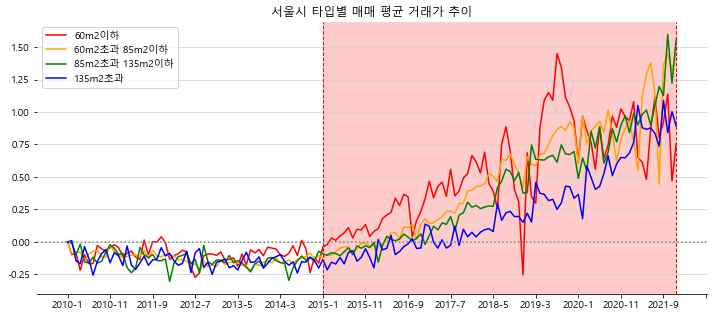

In [52]:
fig, ax = plt.subplots(figsize = (12, 5))

ax.plot(gangnam1['date'], gangnam1['f0_'],c = 'red',label = '60m2이하')
ax.plot(gangnam2['date'], gangnam2['f0_'],c = 'orange',label = '60m2초과 85m2이하')
ax.plot(gangnam3['date'], gangnam3['f0_'],c = 'green',label = '85m2초과 135m2이하')
ax.plot(gangnam4['date'], gangnam4['f0_'],c = 'blue',label = '135m2초과')


# xticks개수 조절
ax.xaxis.set_major_locator(MaxNLocator(16)) 

# 그리드 추가
ax.grid(axis="y", c="lightgray") # "axis = 'x'" 는 x축 세로선 grid생성

# 필요없는 선 제거
ax.spines[["left", "top", "right"]].set_visible(False)

# 0점선
ax.axhline(y=0, c="gray", ls=":") 

# 분양권 상한제 시점 표시
ax.axvspan('2015-1', '2021-12', facecolor='red',alpha = 0.2)
plt.axvline(x='2015-1', color='r', linestyle='--', linewidth=1)
plt.axvline(x='2021-12', color='r', linestyle='--', linewidth=1)


plt.title('서울시 타입별 매매 평균 거래가 추이')
plt.legend()

서울전체랑 강남만해도 조금 다른모습이다. 일단 강남 그래프에서 인사이트를 얻어보고 이후 평당가로 방향을 바꿔보는것은 어떨지 생각해보자 아니면 여기서 차이가나는 평형에 대해 조사해보거나 다른지방도 찾아보는것은어떨까

분양가 상승을 매매평균거래가로 볼수있을까?? 평단가로 봐야하지 않을까??

In [ ]:
# 평단가, 지역별, 